In [1]:
%load_ext autoreload

In [2]:
%run /home/datarian/git/master-thesis-code/notebooks/common_init.ipynb

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [3]:
%run /home/datarian/git/master-thesis-code/notebooks/learning_init.ipynb

Set plot_confusion_matrix()


In [4]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_curve, make_scorer, log_loss, roc_auc_score, recall_score, precision_score, classification_report, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pickle

Using TensorFlow backend.


In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "../../"
CHAPTER_ID = "random_forest"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures", CHAPTER_ID)

if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

# Random Forest

## Loading Data

In [ ]:
with open(pathlib.Path(Config.get("df_store"), "X_train.pd.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_train_all_relevant.pd.pkl"), "rb") as f:
    kdd98_learn_feat_all_relevant = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_train.pd.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
    

with open(pathlib.Path(Config.get("df_store"), "X_val.pd.pkl"), "rb") as f:
    kdd98_val_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_val_all_relevant.pd.pkl"), "rb") as f:
    kdd98_val_feat_all_relevant = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_val.pd.pkl"), "rb") as f:
    kdd98_val_targets = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
X_train = kdd98_learn_feat.values
X_train_all_relevant = kdd98_learn_feat_all_relevant.values
y_train = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values
X_val = kdd98_val_feat.values
X_val_all_relevant = kdd98_val_feat_all_relevant.values
y_val = kdd98_val_targets.loc[:,"TARGET_B"].astype("int64").values

In [8]:
class_weight = {0: 1, 1: len(y_train[y_train == 0])/sum(y_train)}
class_weight

{0: 1, 1: 18.70289106866288}

## OOB fitting 

In [58]:
rf_oob = RandomForestClassifier(
    n_estimators=3000,
    oob_score=True,
    max_features=80,
    max_depth=4,
    random_state=Config.get("random_seed"),
    class_weight="balanced",
    n_jobs=-1
)

In [59]:
rf_oob.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features=80,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=3000, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [60]:
# depth=4, max_features=80, n_estimators=3000:
print(classification_report(y_test,rf_oob.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     18114
           1       0.08      0.53      0.14       969

   micro avg       0.67      0.67      0.67     19083
   macro avg       0.52      0.60      0.47     19083
weighted avg       0.92      0.67      0.76     19083



In [55]:
# depth=3, max_features="sqrt", n_estimators=3000:
print(classification_report(y_test,rf_oob.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     18114
           1       0.07      0.51      0.13       969

   micro avg       0.66      0.66      0.66     19083
   macro avg       0.52      0.59      0.46     19083
weighted avg       0.92      0.66      0.75     19083



In [52]:
# depth=5, max_features="sqrt", n_estimators=2000:
print(classification_report(y_test,rf_oob.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     18114
           1       0.08      0.51      0.14       969

   micro avg       0.68      0.68      0.68     19083
   macro avg       0.52      0.60      0.47     19083
weighted avg       0.92      0.68      0.77     19083



In [48]:
# depth=4, max_features=10, n_estimators=2000:
print(classification_report(y_test,rf_oob.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     18114
           1       0.08      0.52      0.13       969

   micro avg       0.65      0.65      0.65     19083
   macro avg       0.52      0.59      0.46     19083
weighted avg       0.92      0.65      0.75     19083



In [45]:
#depth=4, max_features=40, n_estimators=1600:
print(classification_report(y_test,rf_oob.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     18114
           1       0.08      0.52      0.14       969

   micro avg       0.66      0.66      0.66     19083
   macro avg       0.52      0.60      0.46     19083
weighted avg       0.92      0.66      0.76     19083



In [42]:
# depth=4, max_features = sqrt, n_estimators=1200:
print(classification_report(y_test,rf_oob.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     18114
           1       0.08      0.51      0.13       969

   micro avg       0.66      0.66      0.66     19083
   macro avg       0.52      0.59      0.46     19083
weighted avg       0.92      0.66      0.76     19083



In [ ]:
RANDOM_STATE = Config.get("random_seed")
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_depth=4,
                               max_features="sqrt",
                               class_weight=class_weight,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True,
                               max_depth=4,
                               max_features='log2',
                               oob_score=True,
                               class_weight=class_weight,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=50",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True,
                               max_features=80,
                               max_depth=4,
                               oob_score=True,
                               class_weight=class_weight,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 40
max_estimators = 2500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Setting up pipeline

In [57]:
ovs = RandomOverSampler(sampling_strategy="minority", random_state=Config.get("random_seed"))

rf_classif = RandomForestClassifier(min_impurity_decrease = 1e-7,
                                    class_weight="balanced",
                                    random_state=Config.get("random_seed"))

rf_pipeline = Pipeline([
    ("oversampler", ovs),
    ("forest", rf_classif)
])

## Setting up gridsearch

In [59]:
scoring = {"roc": make_scorer(roc_auc_score),
           "logloss": "neg_log_loss",
           "recall": make_scorer(recall_score)}

# We use the same strategy as for splitting into train / test set to provide cv splits:
cv = StratifiedShuffleSplit(n_splits=5, random_state=Config.get("random_seed"))

param_grid = {
    "oversampler__ratio": [0.1,0.3,0.5],
    "forest__max_depth": [4,6,8],
    "forest__n_estimators": [500, 1000, 1500],
    'forest__min_samples_split': [3, 5, 10],
    'forest__max_features': [20, 50]
}

rf_gridsearch = GridSearchCV(
    rf_classif,
    param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=cv,
    refit="recall",
    return_train_score=True,
    verbose=3)

## Fitting

In [14]:
rf_gridsearch.fit(X_train_all_relevant, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 133.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 211.6min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size='default',
            train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 1, 1: 18.70289106866288}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 6, 8], 'n_estimators': [500, 1000, 1500], 'min_samples_split': [3, 5, 10], 'max_features': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score=True,
       scoring={'roc': make_scorer(roc_auc_score), 'logloss': 'neg_log_loss', 'recall': make_scorer(recall_sco

In [16]:
import pickle
import pathlib
with open(pathlib.Path(Config.get("model_store"), "random_forest_gridsearch.pkl"), "wb") as f:
    pickle.dump(rf_gridsearch, f)

In [7]:
import pickle
import pathlib
with open(pathlib.Path(Config.get("model_store"), "random_forest_gridsearch.pkl"), "rb") as f:
    grid_search = pickle.load(f)

In [8]:
best_estimator = grid_search.best_estimator_

In [9]:
results = grid_search.cv_results_

In [10]:
best_estimator.get_params()

{'bootstrap': True,
 'class_weight': {0: 1, 1: 18.70289106866288},
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 20,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 1e-07,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
y_scores = grid_search.predict_proba(X_test_all_relevant)[:,1]

In [47]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [48]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0., 1.01]);
    plt.xlim([0., 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

     pred_neg  pred_pos
neg      7046     11068
pos       151       818


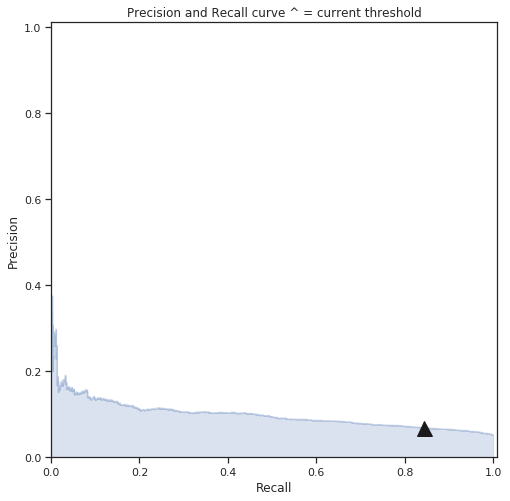

In [51]:
precision_recall_threshold(p,r,thresholds, t=0.43)

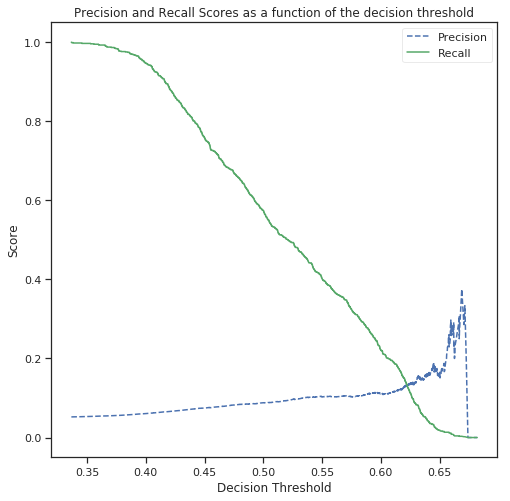

In [24]:
plot_precision_recall_vs_threshold(p,r,thresholds)

In [ ]:
kdd98_learn_feat_all_relevant.columns.values

In [ ]:
gs_features = best_estimator.feature_importances_
gs_important_features = pd.DataFrame(data=gs_features, index=kdd98_learn_feat_all_relevant.columns.values, columns=["feature_importance"])

In [ ]:
gs_important_features = gs_important_features.sort_values(ascending=False, by="feature_importance")

In [ ]:
plt.rcParams['figure.figsize'] = (18, 10)
gs_important_features.head(n=40).sort_values(ascending=True, by="feature_importance").plot.barh()

# Predictions

In [ ]:
y_predict = grid_search.predict(X_test_all_relevant)

In [ ]:
print(classification_report(y_test,y_predict))

In [ ]:
plot_confusion_matrix(y_test,y_predict, [1,0], normalize=True, cmap=Config.get("color_map"))

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test_all_relevant)[:,1],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)